In [ ]:
#my colab ram goes high
#it crashes two times hence we are deleaing with videos
#need patience while doing deep learning projects , as they take some time , for running epoch etc
#always connect with GPUs for training ,takes less time compare to CPU
#better to use colab pro for faster perfomance
#this project can implement in CCTV cameras in all over the world in our real life world, can easy to identify the cops to detect the violence and reach the place on time by using computer vison

In [22]:
!pip install -q kaggle #installing the kaggle`

In [23]:
from google.colab import files
files.upload()

#you can download ur json kaggle file in website by craeting account and uploading here , thats it.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"viveknaidu007","key":"01ba25412e59aed78eb9f83a2ca54ada"}'}

In [25]:
# Make sure the kaggle.json file is present
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 Feb 27 17:52 kaggle.json


In [26]:
%pwd

'/content'

In [27]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  #setting permissions


In [28]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset  #downloading the datasets

#it took me 2minutes 50seconds to download

real-life-violence-situations-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
# Extract the dataset
!unzip real-life-violence-situations-dataset.zip -d real_life_violence_situations_dataset

#40 seconds took me


Archive:  real-life-violence-situations-dataset.zip
replace real_life_violence_situations_dataset/Real Life Violence Dataset/NonViolence/NV_1.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [30]:
!ls

real_life_violence_situations_dataset  real-life-violence-situations-dataset.zip  sample_data


In [31]:
#there are the libraires we need

import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
%matplotlib inline


In [33]:
#hm lets create directory

violence_videos = "/content/real_life_violence_situations_dataset/Real Life Violence Dataset/Violence"
non_violence_videos = "/content/real_life_violence_situations_dataset/Real Life Violence Dataset/NonViolence"

In [34]:
#lets set the variable for videos

violence_list = os.listdir(violence_videos)
non_violence_list = os.listdir(non_violence_videos)

In [35]:
print(len(violence_list))
print(len((non_violence_list)))

#we ahve 1000 videos each in two folders


1000
1000


In [36]:
#lets create random variable or we can just pick any video for using , im using random ,so it will picka any random video

random_violence = random.choice(violence_list)
random_non_violence = random.choice(non_violence_list)


In [38]:
#we are adjusting the frames

img_height , img_width =  64 , 64

# now specify the number of frames of a video that will be fed to the model as one sequence.

sequence_length = 15

In [39]:
dataset_dir = "/content/real_life_violence_situations_dataset/Real Life Violence Dataset"

In [40]:
class_list = ["NonViolence" , "Violence"]

In [41]:
def frames_extraction(video_path):

    frames_list = []

    # read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/sequence_length), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(sequence_length):                    #here we are giving sequence length

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (img_height, img_width))       #here we r giving img height,width

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list

In [42]:
#lets create the data

def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes.
    for class_index, class_name in enumerate(class_list):    # class_list we are defininng

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(dataset_dir, class_name))        #dataset_dir

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(dataset_dir, class_name, file_name)  #dataset_dir

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the sequence_length specified.
            # So ignore the vides having frames less than the sequence_length.
            if len(frames) == sequence_length:                    #sequence_length

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [43]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()


#really it tool me 31 minutes to run , hm lol , we need to alert here , and our colab will disconnect etc

'''i can explain why it was taken this much time ,as a human we know everything , but as a computer it doesnt know what happening in videos
 computers undersatands 0 ,1 , so its converting everyframe into numbers to represent in this own way , i think im right?
'''

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [44]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [45]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

In [46]:
#lets do Encoding and Splitting Training-Testing Sets

# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)


In [47]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [48]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

#(1800 : train data , 15 = sequence_length , 64 = img_height , 64 = img_width , 3 = RGB(red,green,blue))   #by seeing this we can undersatnd below output parametrs

(1800, 15, 64, 64, 3) (1800, 2)
(200, 15, 64, 64, 3) (200, 2)


In [49]:
#lets Importing MobileNet and Fine-Tuning it.

from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

#mobilenet.summary()

9406464/9406464 [==============================] - 1s 0us/step


In [52]:
#lets build the model


def create_model():

    model = Sequential()

    #Specifying Input to match features shape
    model.add(Input(shape = (sequence_length, img_height, img_width, 3)))    #sequence_length , img_height , img_width

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))

    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))


    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))

    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(len(class_list), activation = 'softmax'))     #class_list we r using

    model.summary()

    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 15, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 15, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 15, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

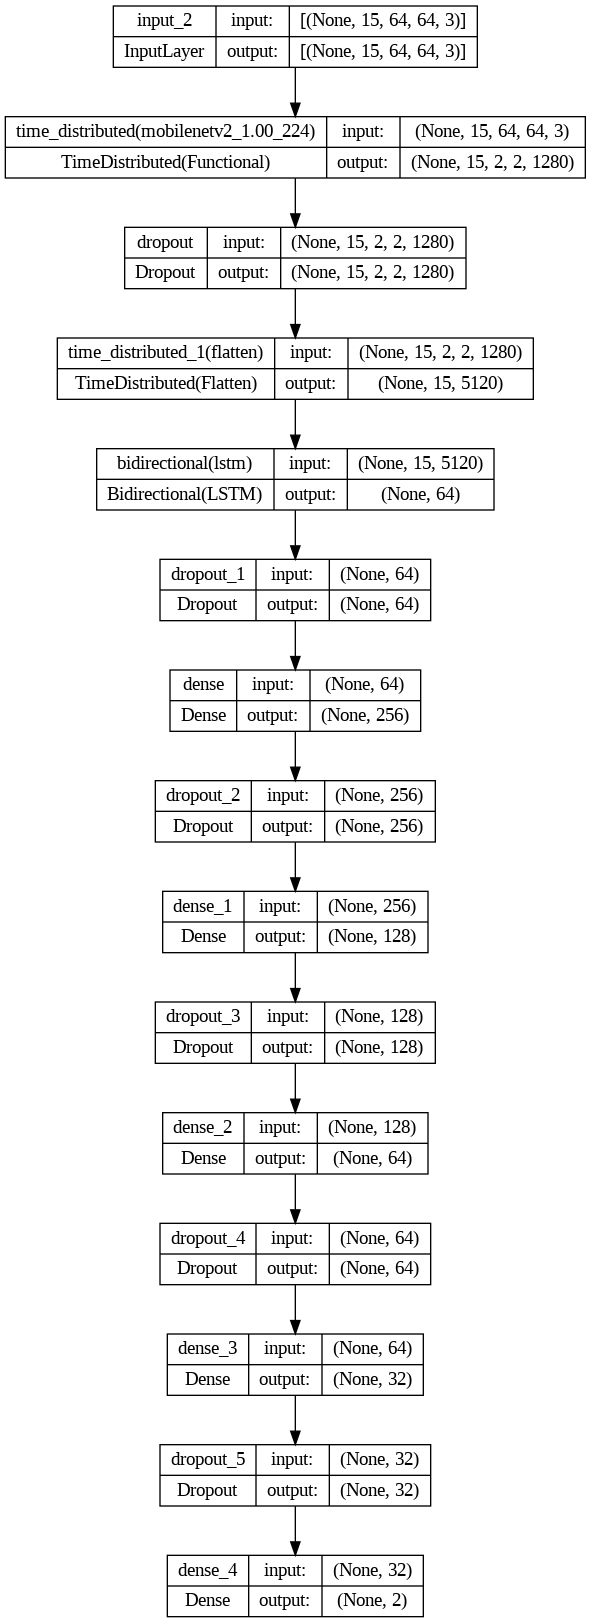

In [53]:
# Constructing the Model
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [55]:
import tensorflow as tf

In [56]:
#now specify the callbacks and fittings

# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

# Compiling the model
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

# Fitting the model
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])



#hence we gave early stops model automatically stops when its reaches to its point high accuracy

#it took me 4 minutes to run

Epoch 1/50
180/180 [==============================] - 28s 73ms/step - loss: 0.6956 - accuracy: 0.5181 - val_loss: 0.6903 - val_accuracy: 0.5250 - lr: 0.0100
Epoch 2/50
180/180 [==============================] - 10s 56ms/step - loss: 0.6909 - accuracy: 0.5250 - val_loss: 0.6900 - val_accuracy: 0.4833 - lr: 0.0100
Epoch 3/50
180/180 [==============================] - 10s 57ms/step - loss: 0.6850 - accuracy: 0.5500 - val_loss: 0.6707 - val_accuracy: 0.6222 - lr: 0.0100
Epoch 4/50
180/180 [==============================] - 11s 60ms/step - loss: 0.6314 - accuracy: 0.6472 - val_loss: 0.5525 - val_accuracy: 0.7722 - lr: 0.0100
Epoch 5/50
180/180 [==============================] - 10s 56ms/step - loss: 0.4984 - accuracy: 0.7812 - val_loss: 0.8372 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 6/50
180/180 [==============================] - 10s 57ms/step - loss: 0.3610 - accuracy: 0.8590 - val_loss: 0.3988 - val_accuracy: 0.8583 - lr: 0.0100
Epoch 7/50
180/180 [==============================] - 11s 

In [57]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

7/7 [==============================] - 5s 56ms/step - loss: 0.2175 - accuracy: 0.9350


In [79]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # geting the epoch count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'red', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'black', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

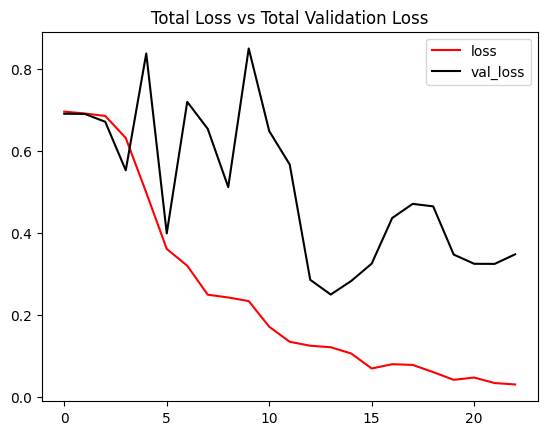

In [80]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

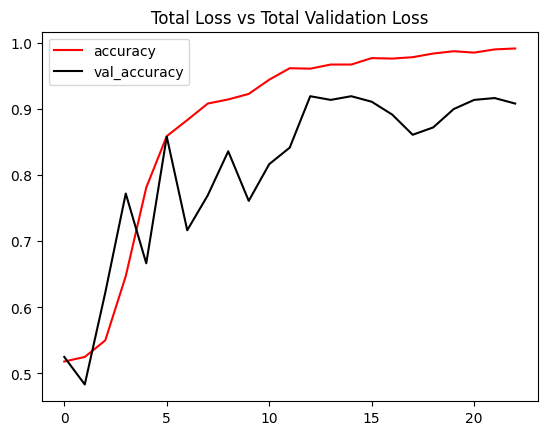

In [81]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [ ]:
#lets now prediction of  test set

In [61]:
labels_predict = MoBiLSTM_model.predict(features_test)

7/7 [==============================] - 3s 62ms/step


In [62]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [63]:
labels_test_normal.shape , labels_predict.shape

((200,), (200,))

In [64]:
#lets see accuracy score of our model

In [65]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.935


In [ ]:
#confusion matrix

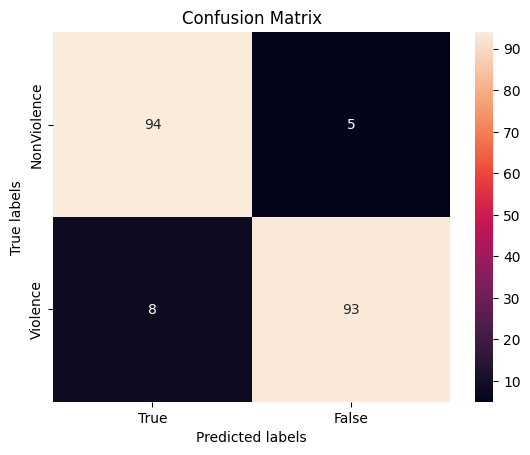

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [ ]:
#classification report

In [67]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94        99
           1       0.95      0.92      0.93       101

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



In [ ]:
#now prediction for the video

In [76]:
def predict_video(video_file_path, sequence_length):                     #sequence_length

    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/sequence_length),1)             #sequence_length

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(sequence_length):                       #sequence_length

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (img_height, img_width))   #img_height , img_width

        # Normalize the resized frame.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = class_list[predicted_label]             #class_list

    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [ ]:
#lets give violence _video

In [78]:
# Specifying video to be predicted
input_video_file_path = "../content/real_life_violence_situations_dataset/Real Life Violence Dataset/Violence/V_100.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, sequence_length)   #sequence_lenth we r giving

# Play the actual video
Play_Video(input_video_file_path)

1/1 [==============================] - 0s 24ms/step
Predicted: Violence
Confidence: 0.9938085675239563


In [ ]:
#lets give non violence video

In [75]:
# Specifying video to be predicted
input_video_file_path = "../content/real_life_violence_situations_dataset/Real Life Violence Dataset/NonViolence/NV_156.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, sequence_length)     #sequence_length
# Play the actual video
Play_Video(input_video_file_path)

1/1 [==============================] - 0s 34ms/step
Predicted: NonViolence
Confidence: 0.9996649026870728
